# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_file = '../data/processed/train.csv'
test_file = '../data/processed/test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Remove date column if exists
if 'date' in train_data.columns:
    train_data['date'] = pd.to_datetime(train_data['date'])
    train_data = train_data.drop(columns=['date'])

if 'date' in test_data.columns:
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data = test_data.drop(columns=['date'])
    
print(f'Train size: {train_data.shape}, Test size: {test_data.shape}')

Train size: (19591, 30), Test size: (144, 30)


In [3]:
from collections import deque

if 'date' in train_data.columns:
    train_data['date'] = pd.to_datetime(train_data['date'])
    train_data = train_data.drop(columns=['date'])

if 'date' in test_data.columns:
    test_data['date'] = pd.to_datetime(test_data['date'])
    test_data = test_data.drop(columns=['date'])

# Keep categorical flags for time awareness
time_features = ['day_of_week', 'time_of_day', 'hour', 'is_weekend']
train_data = train_data[['Appliances'] + time_features]
test_data = test_data[['Appliances'] + time_features]

# Create Lag Features
for lag in range(1, 7):  # Create 6 lags ~ 1 hour
    train_data[f'lag_{lag}'] = train_data['Appliances'].shift(lag)

# Drop NaNs after creating lags
train_data = train_data.dropna()

# Convert time features to categorical
for feature in time_features:
    train_data[feature] = train_data[feature].astype('category')
    test_data[feature] = test_data[feature].astype('category')

# One-hot encode categorical features
train_data = pd.get_dummies(train_data, columns=time_features)
test_data = pd.get_dummies(test_data, columns=time_features)

# Initialize rolling features and lags
rolling_1h = deque(train_data['Appliances'].iloc[-6:].values, maxlen=6)
rolling_1d = deque(train_data['Appliances'].iloc[-144:].values, maxlen=144)
lags = list(train_data['Appliances'].iloc[-6:].values[::-1])
predictions = []

# Pre-build all input features (lags + encoded time features)
time_feature_cols = [col for col in test_data.columns if any(feat in col for feat in time_features)]

full_input_features = pd.DataFrame(index=range(144))
for i in range(6):
    full_input_features[f'lag_{i+1}'] = lags[i]
    
# Add encoded time features
full_input_features = pd.concat([full_input_features, test_data[time_feature_cols].reset_index(drop=True)], axis=1)

X_train = train_data.drop(columns=['Appliances'])
y_train = train_data['Appliances']
X_test = test_data.drop(columns=['Appliances'])
y_test = test_data['Appliances']

# Match columns between train and test
full_input_features = full_input_features.reindex(columns=X_train.columns, fill_value=0)
full_input_features = full_input_features.fillna(0)


print(f'Train features: {X_train.shape}, Train target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test target: {y_test.shape}')


Train features: (19585, 183), Train target: (19585,)
Test features: (144, 171), Test target: (144,)


In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

for t in range(144):
    for i in range(6):  # Loop through 6 lags
        if t  < len(full_input_features):  # Ensure we stay in bounds
            full_input_features.loc[t, f'lag_{i+1}'] = np.int64(lags[i])  # Update lag i+1
    
    input_features = full_input_features.iloc[[t]].copy()

    
    # Update input features with rolling and lag values
    input_features['rolling_mean_1h'] = np.mean(rolling_1h) if len(rolling_1h) > 0 else np.mean(train_data['Appliances'])
    input_features['rolling_std_1h'] = np.std(rolling_1h) if len(rolling_1h) > 0 else np.std(train_data['Appliances'])
    input_features['rolling_mean_1d'] = np.mean(rolling_1d) if len(rolling_1d) > 0 else np.mean(train_data['Appliances'])
    input_features['rolling_std_1d'] = np.std(rolling_1d) if len(rolling_1d) > 0 else np.std(train_data['Appliances'])
    
    # Match columns order
    input_features = input_features.reindex(columns=X_train.columns, fill_value=0)

    # Predict the next value
    pred = np.int64(model.predict(input_features)[0])
    predictions.append(pred)

    # Update rolling features and lags
    for i in range(6):
        if t + 1 < len(full_input_features):  # Ensure we stay within bounds
            full_input_features.loc[t + 1, f'lag_{i+1}'] = lags[i]    
    rolling_1h.append(pred)
    rolling_1d.append(pred)
    lags = [pred] + lags[:-1]


# Error Metrics
rmse = root_mean_squared_error(test_data['Appliances'], predictions)
mae = mean_absolute_error(test_data['Appliances'], predictions)
r2 = r2_score(test_data['Appliances'], predictions)

print('Baseline Model Metrics:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R^2: {r2:.2f}')

#### Predictions

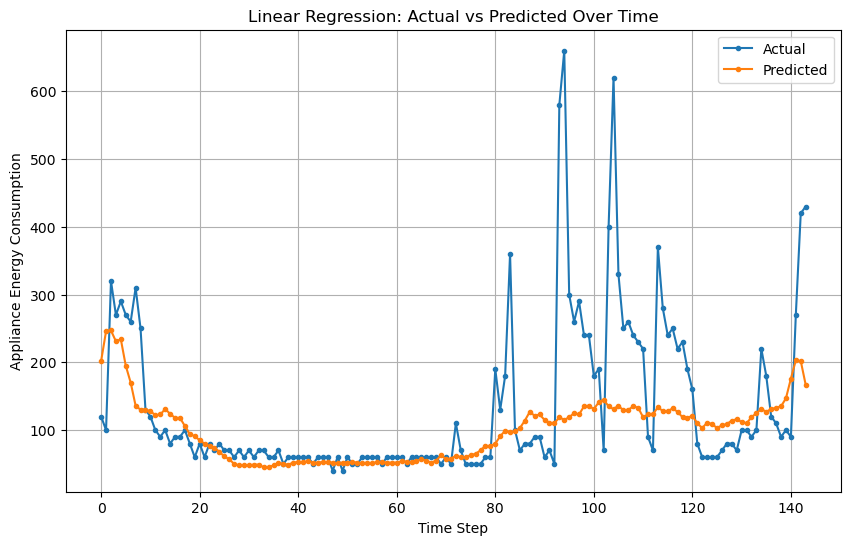

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['Appliances'].values, label='Actual', marker='.')
plt.plot(predictions, label='Predicted', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Linear Regression: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### Residuals

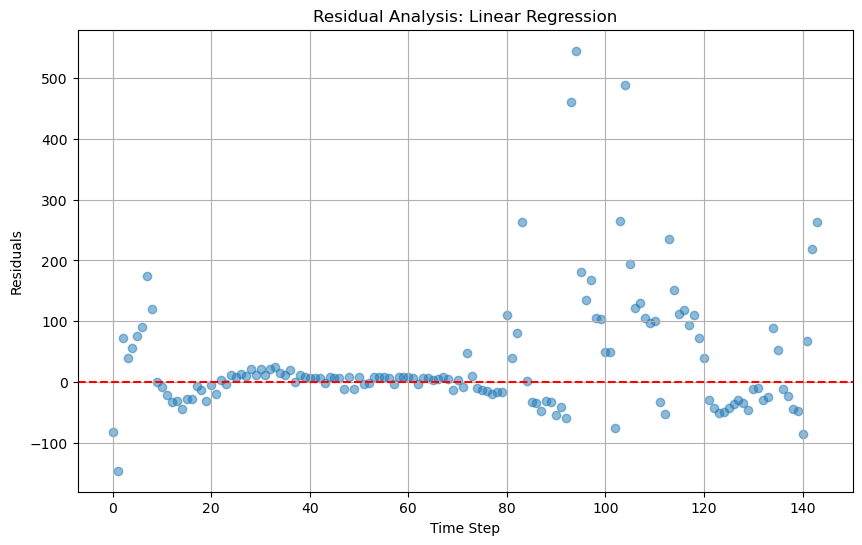

In [10]:
residuals = test_data['Appliances'] - predictions[:144]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residual Analysis: Linear Regression')
plt.grid(True)
plt.show()

Linear model error disturbution is not symmetric around zero, indication non-normality. LM with the current regressors is incapable of capturing the factos incluencing energy consumption during volatile hours. 

## Random Forest Model

In [7]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest Model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print Metrics for Random Forest
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'Random Forest MAE: {mae_rf:.2f}')
print(f'Random Forest R^2: {r2_rf:.2f}')


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- lag_1
- lag_2
- lag_3
- lag_4
- lag_5
- ...


In [ ]:
# Plot Random Forest Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.')
plt.plot(y_pred_rf, label='Predicted (RF)', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Random Forest: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameter Tuning for Random Forest

In [ ]:
# I use randomsearchcv instead of gridsearch to limit run-time. 
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=20, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = random_search.best_estimator_

# Predictions using Tuned Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate Tuned Random Forest Model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print Metrics for Tuned Random Forest
print(f'Tuned Random Forest RMSE: {rmse_rf:.2f}')
print(f'Tuned Random Forest MAE: {mae_rf:.2f}')
print(f'Tuned Random Forest R^2: {r2_rf:.2f}')

In [ ]:
# Plot Tuned Random Forest Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.')
plt.plot(y_pred_rf, label='Predicted (Tuned RF)', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Tuned Random Forest: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()


#### Cross-Validation with Time-Series Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    verbose=2, 
    n_jobs=-1
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_

# Predictions using Tuned Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate Tuned Random Forest Model
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print Metrics for Tuned Random Forest
print(f'Tuned Random Forest RMSE: {rmse_rf:.2f}')
print(f'Tuned Random Forest MAE: {mae_rf:.2f}')
print(f'Tuned Random Forest R^2: {r2_rf:.2f}')

In [ ]:
# Plot Tuned Random Forest Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.')
plt.plot(y_pred_rf, label='Predicted (Tuned RF)', marker='.')
plt.xlabel('Time Step')
plt.ylabel('Appliance Energy Consumption')
plt.title('Tuned Random Forest: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
distinct_hours = X_test['hour'].unique()
print(distinct_hours)

In [ ]:
selected_columns = df[['Appliances', 'lag_1', 'lag_2']]
print(selected_columns.head(5))